In [ ]:
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F  # for resizing
from torch.cuda.amp import autocast, GradScaler

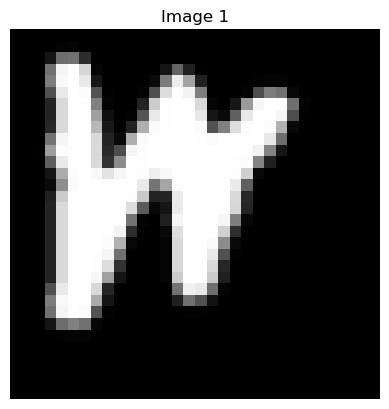

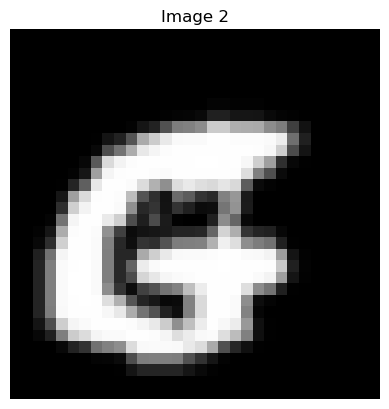

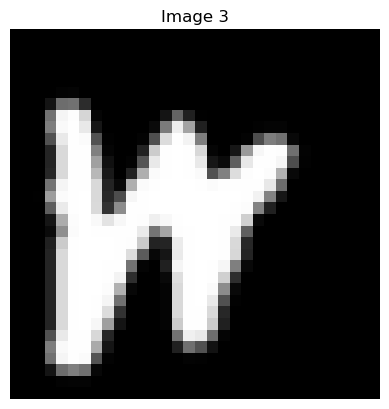

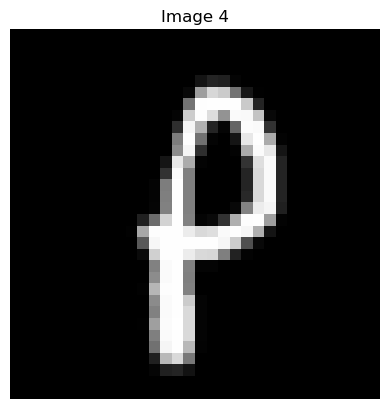

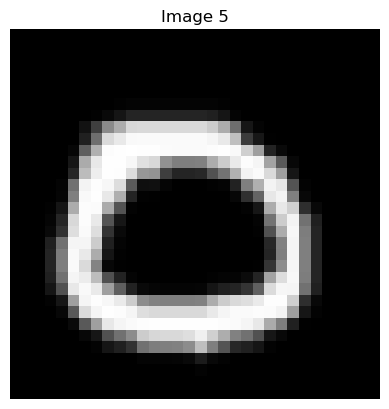

In [21]:
# Open and extract images from the .zip file
def load_images_from_zip(zip_filename):
    """
    Load a numpy array from a .zip archive containing a .npz file.

    Args:
        zip_filename (str): The name of the .zip file to read.

    Returns:
        numpy.ndarray: The loaded array.
    """
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Example usage
loaded_images = load_images_from_zip("corrupted_emnist.zip")

# Show the first 5 images
for i in range(5):
    plt.imshow(loaded_images[i], cmap="gray")
    plt.title(f"Image {i+1}")
    plt.axis("off")
    plt.show()

In [5]:
# Define transformations: convert to tensor and normalize to [-1, 1] range
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Load the MNIST dataset
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)

# Create a DataLoader for batching
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Check dataset size
print(f"Number of samples in MNIST training dataset: {len(mnist_data)}")

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:01<00:00, 9.18MB/s]


Extracting mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 362kB/s]


Extracting mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 3.23MB/s]


Extracting mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.48MB/s]

Extracting mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist_data/MNIST/raw

Number of samples in MNIST training dataset: 60000


In [12]:
# Enable Mac GPU
print(torch.backends.mps.is_available())

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print(device)

True
mps


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


# Define the UNet model for diffusion
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # Keep dimensions: 28x28 -> 28x28
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Downsample: 28x28 -> 14x14
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                128, 64, 3, stride=2, padding=1, output_padding=1
            ),  # Upsample: 14x14 -> 28x28
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),  # Keep dimensions: 28x28 -> 28x28
        )

    def forward(self, x, t):
        # Add time embedding if necessary (simplified here)
        x = self.encoder(x)
        x = self.decoder(x)

        # Resize output to match original image dimensions (28x28)
        x = F.interpolate(
            x, size=(28, 28), mode="bilinear", align_corners=False
        )  # Ensures size is 28x28
        return x


# Diffusion parameters
T = 100  # Number of timesteps
betas = torch.linspace(1e-4, 0.02, T)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)


# Sample noisy images
def add_noise(x0, t):
    noise = torch.randn_like(x0)
    alpha_t = alphas_cumprod[t][:, None, None, None]
    return torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise, noise


# Reverse process
def denoise(model, xt, t):
    return model(xt, t)


# Prepare MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)
mnist_data = datasets.MNIST(
    root="mnist_data", train=True, download=True, transform=transform
)
mnist_loader = DataLoader(mnist_data, batch_size=128, shuffle=True)

# Move model and data to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

# Initialize model, loss, and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

from torch.cuda.amp import autocast, GradScaler

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Training loop with mixed precision
for epoch in range(epochs):
    for images, _ in mnist_loader:  # Labels not used
        images = images.to(device)
        t = torch.randint(0, T, (images.size(0),), device=device)
        xt, noise = add_noise(images, t)

        optimizer.zero_grad()

        # Forward pass with autocast
        with autocast():
            pred_noise = model(xt, t)
            loss = criterion(pred_noise, noise)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Save the trained model
torch.save(model.state_dict(), "diffusion_mnist.pth")

/var/folders/99/2f4hz83j78l051s4_zykpyk40000gn/T/ipykernel_20134/3607390662.py:80: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/Users/felipemansilla/anaconda3/envs/abalone/lib/python3.12/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
/var/folders/99/2f4hz83j78l051s4_zykpyk40000gn/T/ipykernel_20134/3607390662.py:92: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/Users/felipemansilla/anaconda3/envs/abalone/lib/python3.12/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Epoch 1/10, Loss: 0.2237
Epoch 2/10, Loss: 0.1367
Epoch 3/10, Loss: 0.1373
Epoch 4/10, Loss: 0.1527
Epoch 5/10, Loss: 0.1403
Epoch 6/10, Loss: 0.1173
Epoch 7/10, Loss: 0.1225
Epoch 8/10, Loss: 0.1143
Epoch 9/10, Loss: 0.1194
Epoch 10/10, Loss: 0.1035


In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.cuda.amp import autocast, GradScaler
import zipfile
import numpy as np


# Load the corrupted EMNIST images from a .zip file
def load_images_from_zip(zip_filename):
    with zipfile.ZipFile(zip_filename, "r") as zipf:
        npz_filename = zipf.namelist()[0]  # Get the name of the .npz file
        zipf.extract(npz_filename)  # Extract the .npz file
    data = np.load(npz_filename)["all_imagesfinal"]  # Load the array
    return data


# Custom Dataset for loading the corrupted EMNIST images
class CorruptedEMNISTDataset(Dataset):
    def __init__(self, images, transform=None):
        self.images = images
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        if self.transform:
            image = self.transform(image)
        return image


# Load the corrupted EMNIST images
corrupted_images = load_images_from_zip("corrupted_emnist.zip")

# Define the transformation for normalizing and converting to tensor
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
)

# Create a DataLoader for the corrupted EMNIST dataset
corrupted_emnist_dataset = CorruptedEMNISTDataset(corrupted_images, transform=transform)
corrupted_emnist_loader = DataLoader(
    corrupted_emnist_dataset, batch_size=128, shuffle=True
)


# Define the UNet model for diffusion (same as in Step 1)
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),  # Keep dimensions: 28x28 -> 28x28
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),  # Downsample: 28x28 -> 14x14
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(
                128, 64, 3, stride=2, padding=1, output_padding=1
            ),  # Upsample: 14x14 -> 28x28
            nn.ReLU(),
            nn.Conv2d(64, 1, 3, padding=1),  # Keep dimensions: 28x28 -> 28x28
        )

    def forward(self, x, t):
        x = self.encoder(x)
        x = self.decoder(x)

        # Resize output to match original image dimensions (28x28)
        x = F.interpolate(x, size=(28, 28), mode="bilinear", align_corners=False)
        return x


# Diffusion parameters (same as Step 1)
T = 100  # Number of timesteps
betas = torch.linspace(1e-4, 0.02, T)  # Noise schedule
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0).to(device)


# Function to add noise to the original image (same as Step 1)
def add_noise(x0, t):
    # Resize x0 to 28x28 to match model input size
    x0 = F.interpolate(x0, size=(28, 28), mode="bilinear", align_corners=False)

    noise = torch.randn_like(x0)
    alpha_t = alphas_cumprod[t][:, None, None, None]
    return torch.sqrt(alpha_t) * x0 + torch.sqrt(1 - alpha_t) * noise, noise


# Reverse diffusion (denoising)
def denoise(model, xt, t):
    model.eval()
    with torch.no_grad():
        return model(xt, t)


# Load the pre-trained model from MNIST
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)
model.load_state_dict(torch.load("diffusion_mnist.pth"))

# Initialize optimizer, loss function, and GradScaler for mixed precision
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()
scaler = GradScaler()

# Fine-tuning loop on corrupted EMNIST
epochs = 10
for epoch in range(epochs):
    for images in corrupted_emnist_loader:
        images = images.to(device, dtype=torch.float32)  # Explicitly cast to float32
        t = torch.randint(0, T, (images.size(0),), device=device)
        xt, noise = add_noise(images, t)

        optimizer.zero_grad()

        # Forward pass with autocast (for mixed precision)
        with autocast():
            pred_noise = model(xt, t)
            loss = criterion(pred_noise, noise)

        # Backward pass with scaled gradients
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}")

# Save the fine-tuned model
torch.save(model.state_dict(), "fine_tuned_diffusion_emnist.pth")

/var/folders/99/2f4hz83j78l051s4_zykpyk40000gn/T/ipykernel_20134/3833548920.py:106: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("diffusion

Epoch 1/10, Loss: 13.9390
Epoch 2/10, Loss: 5.3543
Epoch 3/10, Loss: 2.9791
Epoch 4/10, Loss: 2.3169
Epoch 5/10, Loss: 1.7804
Epoch 6/10, Loss: 1.2373
Epoch 7/10, Loss: 1.0157
Epoch 8/10, Loss: 0.8752
Epoch 9/10, Loss: 0.6825
Epoch 10/10, Loss: 0.6611


In [27]:
import torch
import numpy as np

# Assuming pred_noise is the denoised output and xt is the corrupted input
# Both are tensors with shape [batch_size, 1, 28, 28] (or similar)

# Compute the reconstruction error (MSE) between the corrupted and denoised images
reconstruction_errors = torch.mean(
    (xt - pred_noise) ** 2, dim=[1, 2, 3]
)  # Mean squared error per image

# Calculate the mean and standard deviation of the reconstruction errors
mean_error = torch.mean(reconstruction_errors).item()
std_error = torch.std(reconstruction_errors).item()

# Set the threshold for anomalies (3 standard deviations away from the mean)
threshold = mean_error + 2 * std_error

# Flag anomalies
anomalies = reconstruction_errors > threshold

# Print the results
print(f"Mean Reconstruction Error: {mean_error}")
print(f"Standard Deviation of Reconstruction Error: {std_error}")
print(f"Threshold for Anomalies: {threshold}")

# Visualize or count anomalies
num_anomalies = torch.sum(anomalies).item()
print(f"Number of Anomalies: {num_anomalies}")

# Optionally, visualize the anomaly map for the first few images
import matplotlib.pyplot as plt

for i in range(5):  # Visualize first 5 anomalies (if any)
    if anomalies[i]:
        corrupted_image = xt[i].cpu().detach().numpy().squeeze()  # Corrupted image
        denoised_image = (
            pred_noise[i].cpu().detach().numpy().squeeze()
        )  # Denoised image

        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(corrupted_image, cmap="gray")
        plt.title("Corrupted Image")
        plt.axis("off")

        plt.subplot(1, 2, 2)
        plt.imshow(denoised_image, cmap="gray")
        plt.title("Denoised Image")
        plt.axis("off")

        plt.show()

Mean Reconstruction Error: 19406.7734375
Standard Deviation of Reconstruction Error: 9017.958984375
Threshold for Anomalies: 46460.650390625
Number of Anomalies: 1


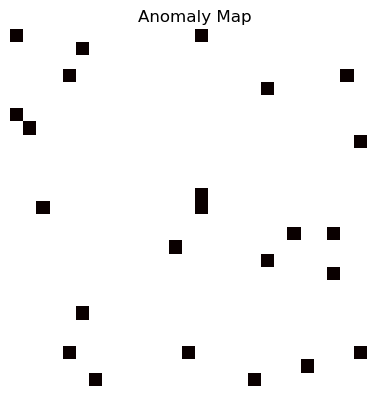

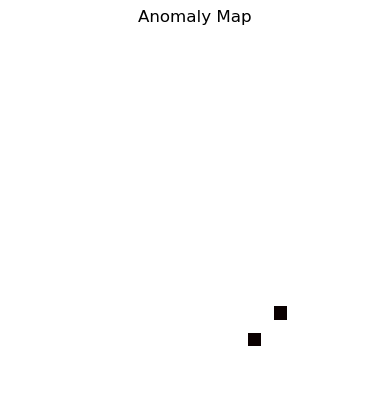

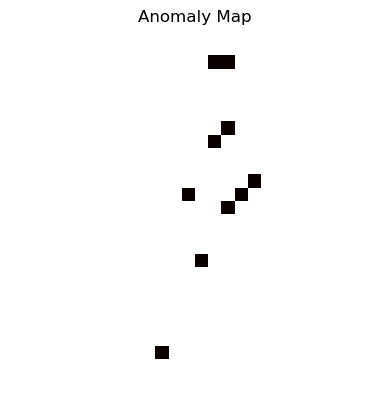

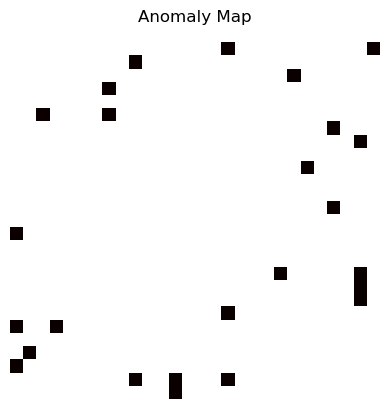

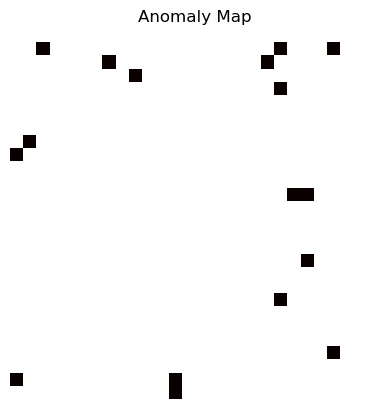

In [26]:
# Compute absolute pixel-wise differences between the corrupted and denoised images
pixel_diff = torch.abs(xt - pred_noise)

# Thresholding to flag large differences as anomalies
threshold = 0.1  # This is a hyperparameter you can adjust
anomalies = pixel_diff > threshold

# Visualize or count anomalies
for i in range(5):
    anomaly_mask = (
        anomalies[i].cpu().detach().numpy().squeeze()
    )  # Binary mask for anomalies

    plt.imshow(anomaly_mask, cmap="hot")  # Hot color map for anomalies
    plt.title("Anomaly Map")
    plt.axis("off")
    plt.show()

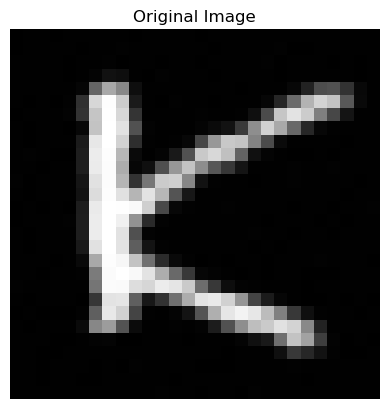

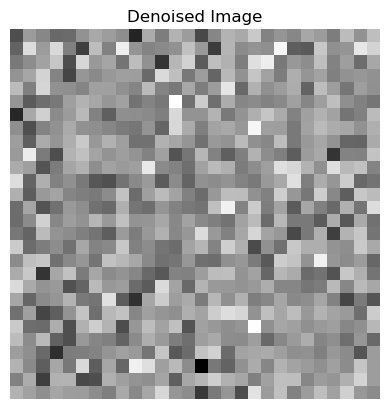

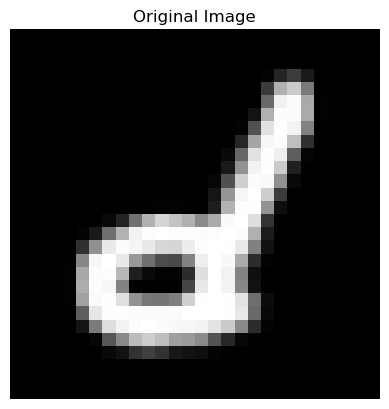

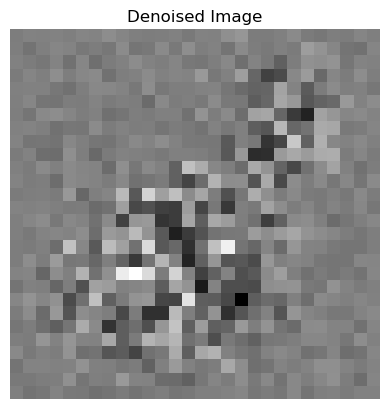

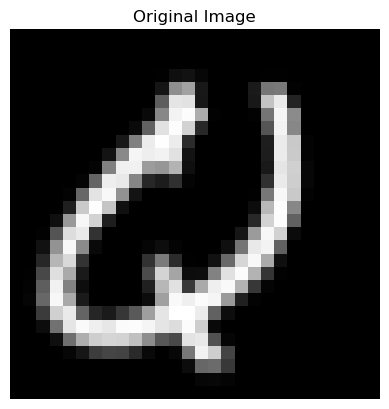

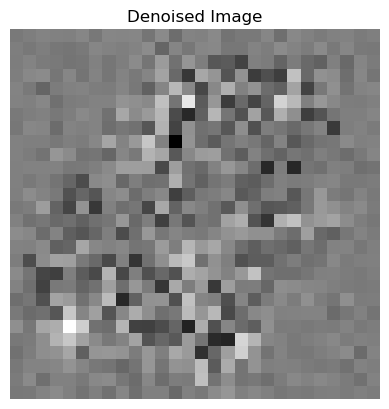

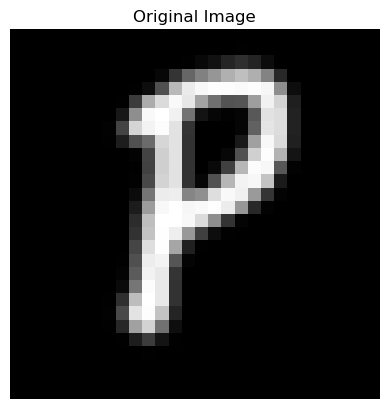

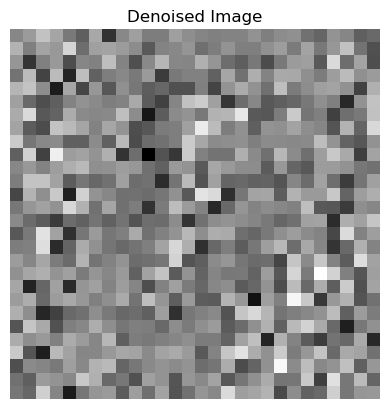

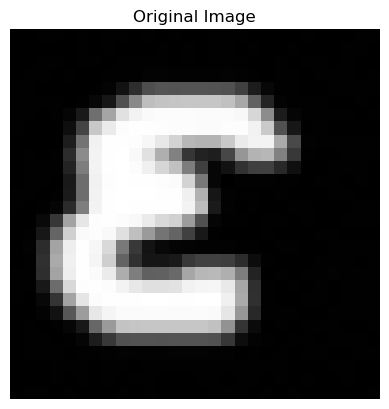

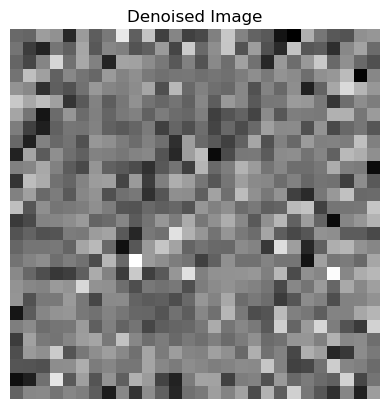

In [28]:
# Visualize the anomalies for the first 5 images
for i in range(5):
    plt.imshow(xt[i].cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title("Original Image")
    plt.axis("off")
    plt.show()

    plt.imshow(pred_noise[i].cpu().detach().numpy().squeeze(), cmap="gray")
    plt.title("Denoised Image")
    plt.axis("off")
    plt.show()